In [ ]:
"""Template for jupyter notebooks created within this directory. Adds the parent directory to path and sets autoreload."""

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys

# Get the current working directory
cwd = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(cwd)

# Get the grandparent directory (two levels above)
root_dir = os.path.dirname(parent_dir)

# Add the root directory to sys.path
if root_dir not in sys.path:
    sys.path.append(root_dir)

print(f"Root directory: {root_dir} is added to sys.path")


Root directory: /Users/aag/Documents/proteinfolding is added to sys.path


In [3]:
from proteinfolding import * 

##TODO: proper testing ##

In [4]:
# for training and running trianed cirucits
from proteinfolding.data_processing import *
from proteinfolding.paths import XY_QAOA_DATA_DIR, EXACT_DATA_ENERGY_BITSTRING_FILE, MIN_SHOTS_TO_FIND_GS_FILE
from proteinfolding.simulations_production import statevector_simulation_XY_parallel_trained, statevector_simulation_XY_parallel_new

SIMULATION_ID = "A125769"
PROCESSED_DATA_DIR = os.path.join(XY_QAOA_DATA_DIR, SIMULATION_ID)

/Users/aag/Documents/proteinfolding/notebooks/local_testing
┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2025 [Rosetta PyRosetta4.Release.python310.m1 2025.06+release.029c6a159b896477003a14f78f472d4cd2cead46 2025-02-04T15:14:13] retrieved from: http://www.pyrosetta.org
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.pyt

In [5]:
file_path = os.path.join(root_dir, "notebooks/local_testing/QPU_calls_stats.csv")

df_qpu = pd.read_csv(file_path)

SA LOOCV Slope: 0.087 ± 0.003
SA Exp Fit: A = 1.51e+05, B = 0.086 ± 0.007, R² = 0.8209
QAOA Statevector LOOCV Slope: 0.039 ± 0.009
QAOA Statevector Exp Fit: A = 1.00e+02, B = 0.039 ± 0.035, R² = 0.0279
QAOA MPS LOOCV Slope: 0.038 ± 0.004
QAOA MPS Exp Fit: A = 4.53e+03, B = 0.038 ± 0.014, R² = 0.6043


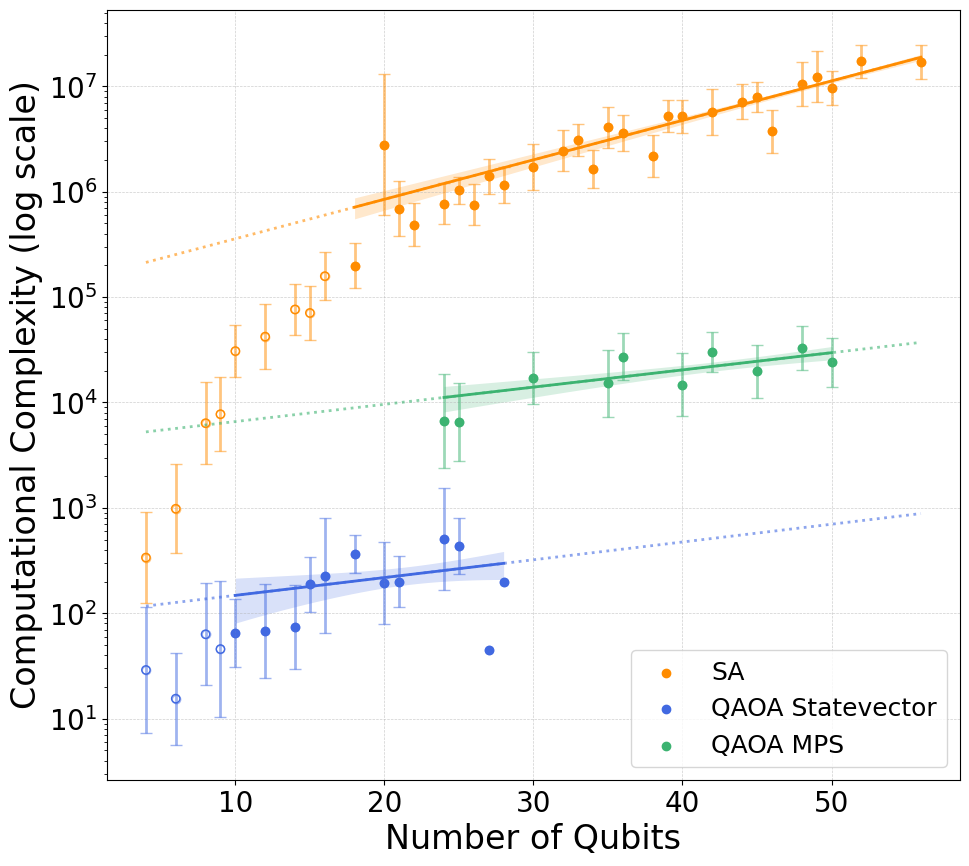

In [6]:
from proteinfolding.plotter_statevector_mps import DataPlotter

cpu_df = pd.read_csv("complexity_SA_stats.csv")
qpu_df = pd.read_csv("QPU_calls_stats.csv")
qpu_df_mps = pd.read_csv("QPU_calls_stats_mps.csv")

save_path="/Users/aag/Documents/proteinfolding/plots/xy_qaoa/cpu_vs_qpu"

plotter = DataPlotter(cpu_df, qpu_df, qpu_df_mps)

plotter.plot_scaling_semilog_exp_fit(save_path)

SA $(\div 10^9 Hz)$ LOOCV Slope: 0.087 ± 0.003
SA $(\div 10^9 Hz)$ Exp Fit: A = 1.51e-04, B = 0.086 ± 0.007, R² = 0.8209
QAOA Statevector $(\div 10^3 Hz)$ LOOCV Slope: 0.039 ± 0.009
QAOA Statevector $(\div 10^3 Hz)$ Exp Fit: A = 1.00e-01, B = 0.039 ± 0.035, R² = 0.0279
QAOA MPS $(\div 5 \cdot 10^4 Hz)$ LOOCV Slope: 0.038 ± 0.004
QAOA MPS $(\div 5 \cdot 10^4 Hz)$ Exp Fit: A = 9.05e-02, B = 0.038 ± 0.014, R² = 0.6043
 LOOCV Slope: 0.087 ± 0.003
 Exp Fit: A = 1.51e-04, B = 0.086 ± 0.007, R² = 0.8209
 LOOCV Slope: 0.039 ± 0.009
 Exp Fit: A = 1.00e-01, B = 0.039 ± 0.035, R² = 0.0279
 LOOCV Slope: 0.038 ± 0.004
 Exp Fit: A = 9.05e-02, B = 0.038 ± 0.014, R² = 0.6043

Crossover point between SA and SV upper error band:
x = 739.83 qubits, estimated runtime ≈ 7.43e+23 seconds


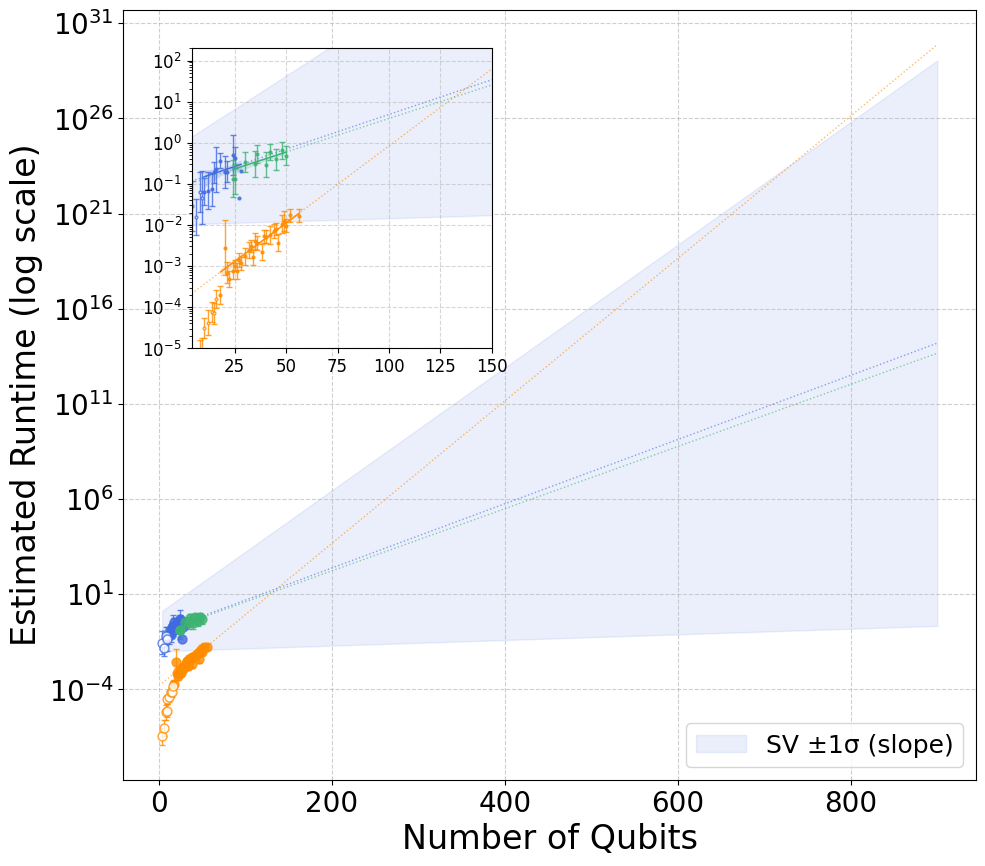

In [7]:
plotter.plot_scaling_normalized(save_path='/Users/aag/Documents/proteinfolding/plots/xy_qaoa/cpu_vs_qpu')

# Plot

In [56]:
from scipy.optimize import curve_fit
import numpy as np
from sklearn.metrics import r2_score

# --- Prepare x, y, yerr ---
# x = df_qpu["num_qubits"].values.astype(float)
# y = np.clip(df_qpu["qpu_calls_mean"].values, 1e-12, None)
# yerr = np.clip(df_qpu["std_qpu_calls"].values, 1e-12, None)

MIN_QUBITS = 10  # Global minimum qubit threshold

def exp_func(x, A, B):
    return A * np.exp(B * x)

# Exponential fit
def exp_fit(x, y, yerr):
    try:
        mask = x >= MIN_QUBITS
        popt, _ = curve_fit(exp_func, x[mask], y[mask], p0=(50, 0.1))
        y_pred = exp_func(x, *popt)
        r2 = r2_score(np.log(y[mask]), np.log(y_pred[mask]))
        return y_pred, popt[1], popt[0], r2
    except:
        return None, None, None, -np.inf

# Log-linear fit
def log_linear_fit(x, y):
    mask = x >= MIN_QUBITS
    logy = np.log(y[mask])
    coeffs = np.polyfit(x[mask], logy, 1)
    y_pred = np.exp(coeffs[1] + coeffs[0] * x)
    r2 = r2_score(logy, coeffs[0] * x[mask] + coeffs[1])
    return y_pred, coeffs[0], np.exp(coeffs[1]), r2

# Power-law fit
def power_law_fit(x, y):
    mask = x >= MIN_QUBITS
    logx = np.log(x[mask])
    logy = np.log(y[mask])
    coeffs = np.polyfit(logx, logy, 1)
    y_pred = np.exp(coeffs[1]) * x**coeffs[0]
    r2 = r2_score(logy, coeffs[0] * logx + coeffs[1])
    return y_pred, coeffs[0], np.exp(coeffs[1]), r2

    
# Aggregate
def aggregate_stats_with_n(df, mean_col, std_col, n_col):
    def pooled_std_weighted(group):
        if len(group) == 1:
            return group[std_col].iloc[0]
        else:
            dof = group[n_col] - 1
            numerator = (dof * group[std_col] ** 2).sum()
            denominator = dof.sum()
            return np.sqrt(numerator / denominator) if denominator > 0 else np.nan

    return df.groupby("num_qubits").apply(
        lambda group: pd.Series({
            mean_col: group[mean_col].mean(),
            std_col.replace("mean", "std"): pooled_std_weighted(group)
        })
    ).reset_index()



/var/folders/zr/_ww60qvd18j868qh1qhtky300000gn/T/ipykernel_29265/3803795300.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("num_qubits").apply(


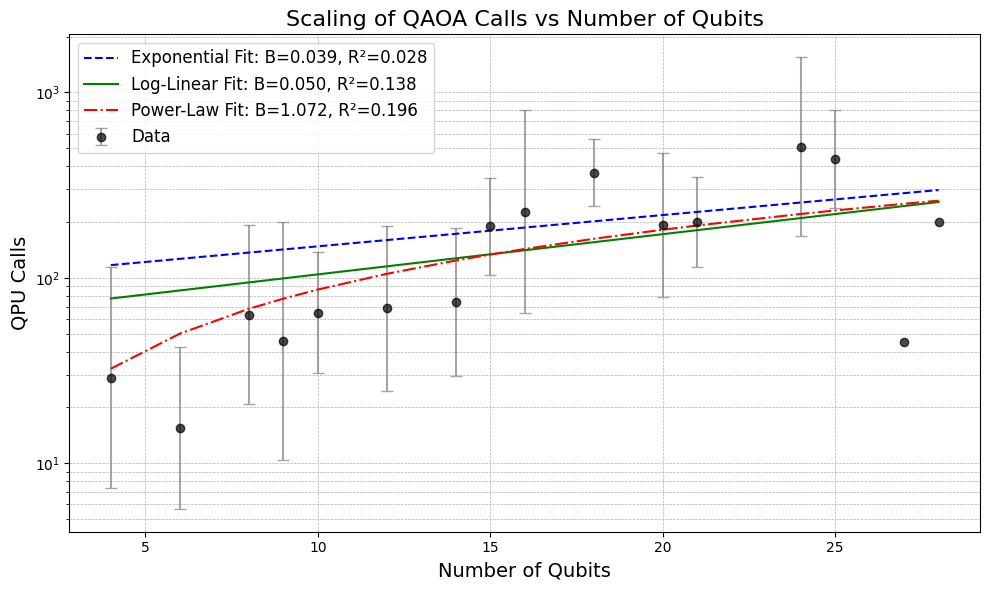

In [57]:
agg_df = aggregate_stats_with_n(df_qpu, "qpu_calls_mean", "std_qpu_calls", "n_runs")

x = agg_df["num_qubits"].values
y = agg_df["qpu_calls_mean"].values
yerr = agg_df["std_qpu_calls"].values

# --- Perform all fits ---
exp_y, exp_B, exp_A, exp_r2 = exp_fit(x, y, yerr)
log_y, log_B, log_A, log_r2 = log_linear_fit(x, y)
pwr_y, pwr_B, pwr_A, pwr_r2 = power_law_fit(x, y)

# --- Plot ---
plt.figure(figsize=(10, 6))
# Convert symmetric error to asymmetric log-space error bars
log_lower = y / np.exp(yerr / y)  # lower bound
log_upper = y * np.exp(yerr / y)  # upper bound
asym_err = np.vstack([y - log_lower, log_upper - y])

plt.errorbar(
    x, y,
    yerr=asym_err,
    fmt='o',
    label='Data',
    color='black',
    capsize=4,
    ecolor='gray',
    elinewidth=1.5,
    alpha=0.7
)
plt.yscale("log")

if exp_y is not None:
    plt.plot(x, exp_y, label=f'Exponential Fit: B={exp_B:.3f}, R²={exp_r2:.3f}', linestyle='--', color='blue')
plt.plot(x, log_y, label=f'Log-Linear Fit: B={log_B:.3f}, R²={log_r2:.3f}', linestyle='-', color='green')
plt.plot(x, pwr_y, label=f'Power-Law Fit: B={pwr_B:.3f}, R²={pwr_r2:.3f}', linestyle='-.', color='red')

plt.xlabel("Number of Qubits", fontsize=14)
plt.ylabel("QPU Calls", fontsize=14)
plt.title("Scaling of QAOA Calls vs Number of Qubits", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

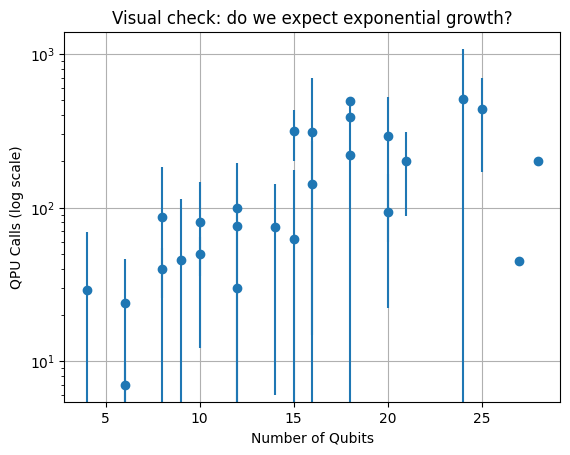

In [24]:
import matplotlib.pyplot as plt

plt.errorbar(x, y, yerr=yerr, fmt='o')
plt.yscale("log")
plt.xlabel("Number of Qubits")
plt.ylabel("QPU Calls (log scale)")
plt.title("Visual check: do we expect exponential growth?")
plt.grid(True)
plt.show()


In [29]:
log_y = np.log(y)
# Clip yerr to avoid division by zero or extreme values
yerr = np.clip(yerr, 1e-8, None)
weights = 1 / yerr
valid = np.isfinite(weights) & np.isfinite(log_y)
x_valid = x[valid]
log_y_valid = log_y[valid]
weights_valid = weights[valid]

# Now fit
coeffs = np.polyfit(x_valid, log_y_valid, deg=1, w=weights_valid)


# Do weighted linear fit

B = coeffs[0]
logA = coeffs[1]
A = np.exp(logA)

# R²
from sklearn.metrics import r2_score
log_y_pred = B * x + logA
r2 = r2_score(log_y, log_y_pred)

print(f"Fit: A = {A:.2e}, B = {B:.4f}, R² = {r2:.4f}")


Fit: A = 7.46e-01, B = 0.3850, R² = -2.9910


In [26]:
popt, pcov = curve_fit(exp_func, x, y, p0=(1.0, 0.05), sigma=yerr, absolute_sigma=True)


/var/folders/zr/_ww60qvd18j868qh1qhtky300000gn/T/ipykernel_29265/398294920.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(exp_func, x, y, p0=(1.0, 0.05), sigma=yerr, absolute_sigma=True)
